# Insurance Project: Can we estimate insurance fees with biographical data?
The purpose of this project is to determine if insurance costs can be predicted by any of the following measures: Age, Sex, BMI, # of Children, Smoker (binary) or Region.

Some key questions to be asked:

- Do the elderly pay more than the young?
- Do men pay more than women?
- Do smokers pay more than non-smokers?
- Do the physically unhealthy (i.e. higher BMI) pay more than the physically healthy?
- Do those with more children pay more than the childless (i.e. due to higher levels of stress)?
- Is there a difference between regions in payment?
- Which of these factors is the most decisive in determining insurance charges?
- Can the factors be combined to give a more wholesome view of the subject?

The data was taken from Kaggle: https://www.kaggle.com/datasets/mirichoi0218/insurance

# Summary of Findings

- Smoking has the highest positive correlation with high insurance charges (0.79)
- The average smoker pays $24000 more than non-smokers
- Age and BMI both have slight positive correlations with charges (0.3 and 0.2)
- Older, obese smokers have the highest of insurance charges (age 50+, BMI 30+, smoker == yes)
- Men are more likely to be smokers and are consequently more likely to be obese and cost more in insurance
- Of non-smokers, women cost slightly more in insurance fees than men
- OLS Linear Regression model yielded an r-squared of 0.796, while L1 and L2 regression did not change the r-squared by much
- Random Forest Regression model yielded a far better r-squared of 0.976

In [312]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_style('whitegrid') # Setting plot style
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Importing data

In [313]:
df = pd.read_csv(r"C:\Users\dchit\OneDrive\Documents\GitHub\Datasets\insurance.csv")

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


## Checking datatypes and null values

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [315]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

<br>

1338 values for all variables with no null values.

<br>

In [316]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

We can see at a cursory glance that there are 6 variables involved in this data set which can potentially be used to predict insurance charges: one float, two integers and three string objects. Let us begin with a basic analysis of insurance claims before we move on to each of the variables.

<br>

## Overview of Insurance Charges

<br>

In [317]:
df.describe()

,age,bmi,children,charges
count,1338.000,1338.000,1338.000,1338.000
mean,39.207,30.663,1.095,13270.422
std,14.050,6.098,1.205,12110.011
min,18.000,15.960,0.000,1121.874
25%,27.000,26.296,0.000,4740.287
50%,39.000,30.400,1.000,9382.033
75%,51.000,34.694,2.000,16639.913
max,64.000,53.130,5.000,63770.428


Text(0, 0.5, 'Frequency')

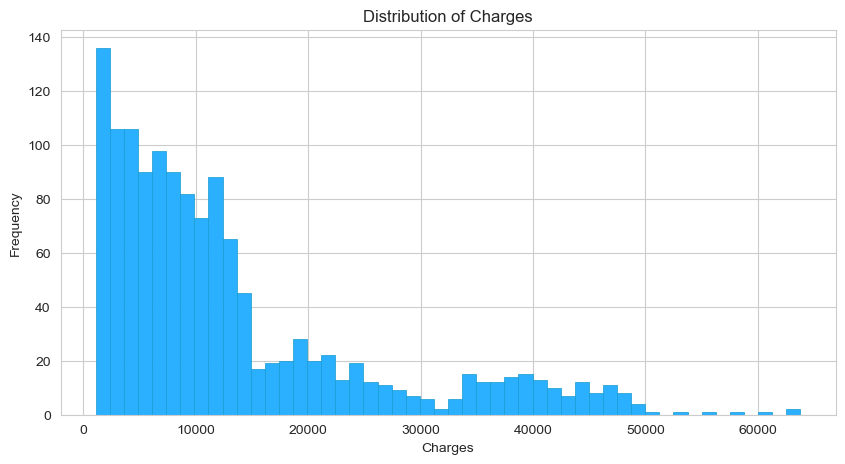

In [318]:
plt.figure(figsize=(10,5))
plt.hist(df['charges'], bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')

<br>

Naturally speaking, sickly people in need of higher health expenditure are less common in society, and hence the count of individuals is less frequent as the insurance cost rises. The charges are heavily concentrated in the lower range (about \\$0-\\$15000) before dropping off significantly. We can see that the mininum charge is \\$1338 and the maximum is \\$63770. The average cost of insurance is \\$13270. 

We shall go through each variable in turn and see how they affect the distribution in insurance charges in an interrelated manner. Let's observe the relationships between variables first through a correlation matrix.

<br>

## Correlation Matrix

The correlation matrix will allow us to take a quick glance at the relationships between the variables and the cost for insurance. Ideally, we are looking for strong positive or negative relationships with insurance charges. Since some of the data is stored as string values or binary strings, we will first convert them to integers in order to facilitate an easy analysis.

<br>

In [319]:
# Replacing strings with integers in order to form correlation.

le = LabelEncoder()

le.fit(df.sex.drop_duplicates())
df.sex=le.transform(df.sex)

le.fit(df.smoker.drop_duplicates())
df.smoker=le.transform(df.smoker)

le.fit(df.region.drop_duplicates())
df.region=le.transform(df.region)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.924
1,18,1,33.770,1,0,2,1725.552
2,28,1,33.000,3,0,2,4449.462
3,33,1,22.705,0,0,1,21984.471
4,32,1,28.880,0,0,1,3866.855


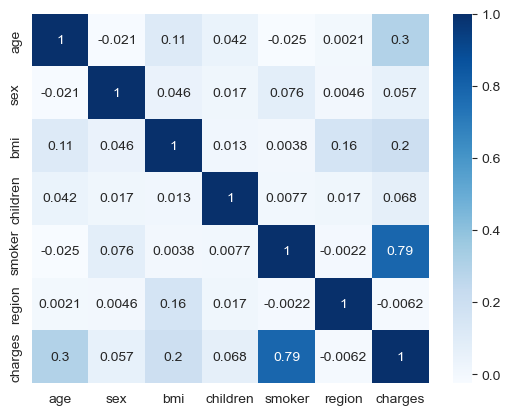

In [320]:
# Visualizing the correlation matrix.

CorrMatrix = sns.heatmap(df.corr(), annot=True, cmap='Blues')

We can immediately see that there is a very high correlation between smoking and insurance fees (0.79). This tells us immediately that we ought to form other visuals and analyses with this fact in mind. There are also mild correlations with Age (0.3) and BMI (0.2). We ought to look at both of these and see if the relationships between the variables overlap with one another.

Given the fact that Smoking is the variable with the highest correlation with insurance charges, let us begin with analyzing smokers to see how they differ from non-smokers.

<br>

## Smoking

In [321]:
# Creating new data frames for smokers and non-smokers.

smokers = df.query('smoker == 1')
non_smokers = df.query('smoker == 0')

In [322]:
smokers.mean()

age           38.515
sex            0.580
bmi           30.708
children       1.113
smoker         1.000
region         1.511
charges    32050.232
dtype: float64

In [323]:
non_smokers.mean()

age          39.385
sex           0.486
bmi          30.652
children      1.090
smoker        0.000
region        1.517
charges    8434.268
dtype: float64

We can see a monumental difference between the insurance charges of smokers and non-smokers. Smokers pay on average \\$24000 more than non-smokers. We can see that the sex-gap is in favor of males (0.580 > 0.486, where 1 is male and 0 is female) but the other variables are all rather constant.

Let us visualize this through a graph.

Text(0, 0.5, 'Frequency')

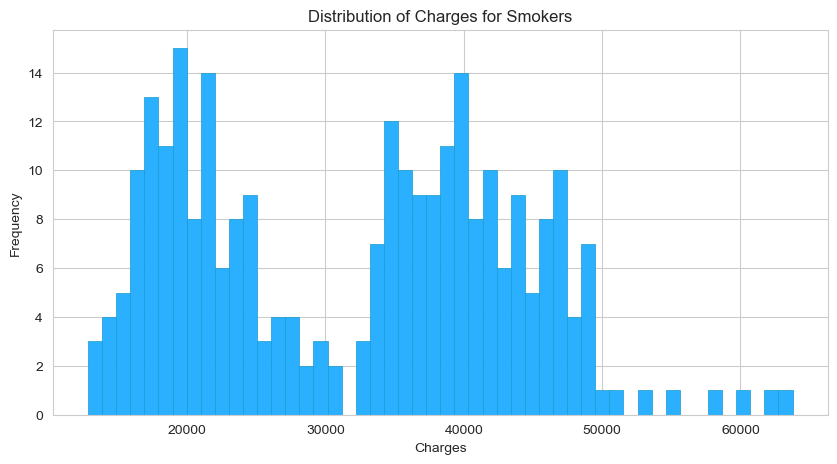

In [324]:
plt.figure(figsize=(10,5))
plt.hist(smokers['charges'], bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Distribution of Charges for Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

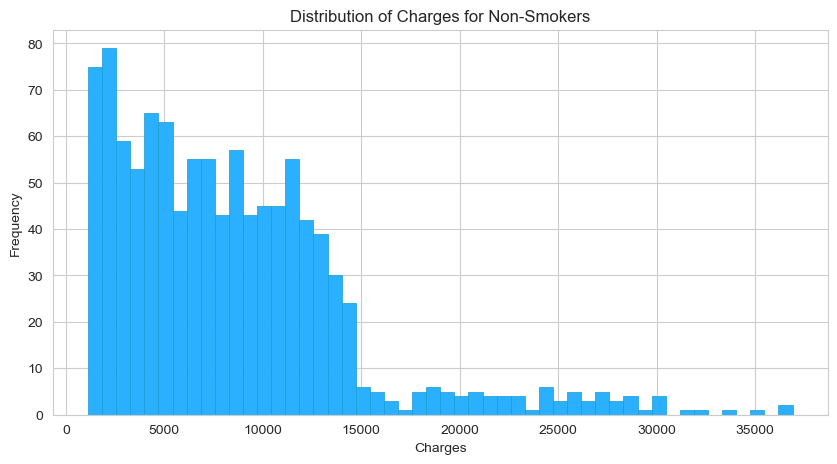

In [325]:
plt.figure(figsize=(10,5))
plt.hist(non_smokers['charges'], bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Distribution of Charges for Non-Smokers')
plt.xlabel('Charges')
plt.ylabel('Frequency')

The histograms tell us that smokers can be divided into two groups: those who develop health issues and those who do not. The right hump is likely those who <i>do</i> develop smoking-related health issues and the left hump must be those who do <i>not</i>. The left hump of smokers overlaps with the left hump of non-smokers. 

While it is not clear what these health issues for smokers may specifically be, the graph evidently shows a split in the data and will likely be reflected in the remaining variables as well. Non-smokers solely have a left hump before the frequency falls off beyond \\$15000, which suggests that they are highly unlikely to develop health issues.

Let us continue on to Age and see how an individual's age is related to their smoking habits or insurance charges.

## Age

In [326]:
df.describe()

,age,sex,bmi,children,smoker,region,charges
count,1338.000,1338.000,1338.000,1338.000,1338.000,1338.000,1338.000
mean,39.207,0.505,30.663,1.095,0.205,1.516,13270.422
std,14.050,0.500,6.098,1.205,0.404,1.105,12110.011
min,18.000,0.000,15.960,0.000,0.000,0.000,1121.874
25%,27.000,0.000,26.296,0.000,0.000,1.000,4740.287
50%,39.000,1.000,30.400,1.000,0.000,2.000,9382.033
75%,51.000,1.000,34.694,2.000,0.000,2.000,16639.913
max,64.000,1.000,53.130,5.000,1.000,3.000,63770.428


The average age of the individual is 39.21 years. We can imagine that the likelihood of someone being sick is higher as they age, so let us look at a visual representation of the data.

<br>

Text(7.625000000000009, 0.5, 'Amount')

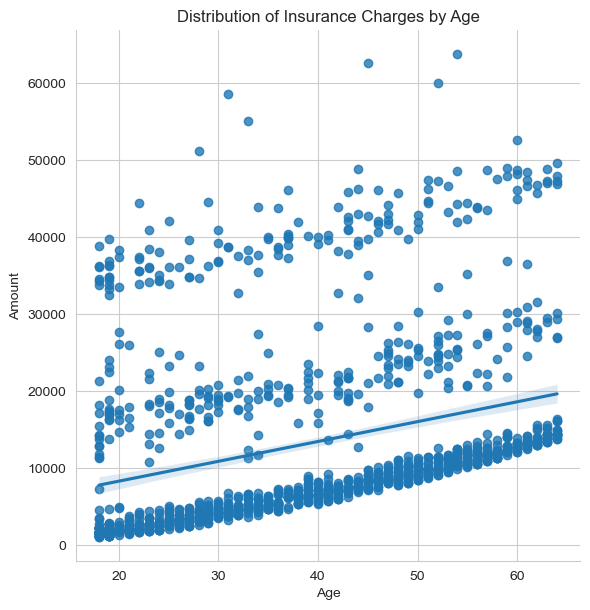

In [327]:
sns.lmplot(x='age', y='charges', data=df, height=6)

plt.title('Distribution of Insurance Charges by Age')
plt.xlabel('Age')
plt.ylabel('Amount')

<br>

As we can see, the cost of insurance does indeed increase along with age (i.e. a positive correlation). We do notice, however, various clusters of data evolving along three different groups - a large collection of data points in the lower section and two smaller collections in the middle and upper sections. It is quite possible that a confounding variable is involved in this matter. Let us take a quick look at the correlation between Age and Smoking.

<br>

## Age & Smoking

Text(0.5, 1.0, 'Distribution of Insurance Charges by Age & Smoking Habit')

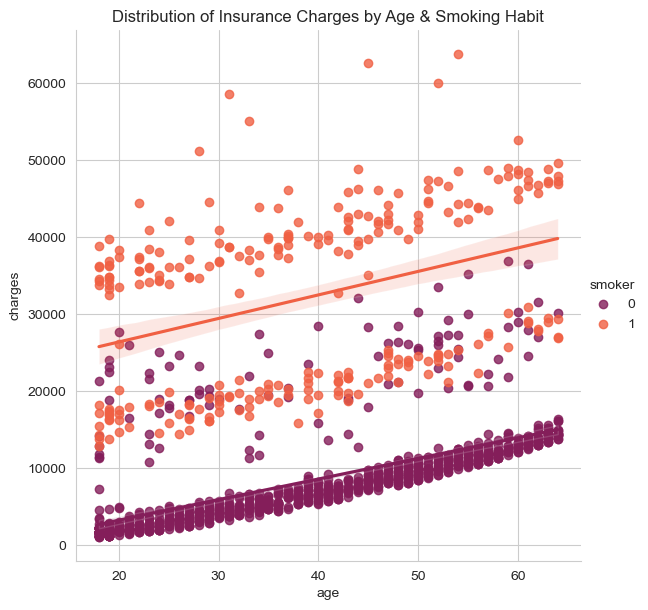

In [328]:
sns.lmplot(x='age', y='charges', hue='smoker', data=df, palette='rocket', height=6)
plt.title('Distribution of Insurance Charges by Age & Smoking Habit')

Given that smokers have a value of 1 and non-smokers of 0, we can clearly see that smokers have higher insurance costs than non-smokers. This should not be surprising at all given the long history of lung- and heart-related issues which heavy smokers tend to suffer from (among other health issues). 

Nevertheless, the two groups are still split in half. While the upper section is mostly smokers and the lower section mostly non-smokers, we can clearly see that the middle section is split: some are smokers and some are non-smokers. It is as of yet possible that more confounding variables are playing a role in determining insurance charges.

As we had mentioned before, a possible explanation of the split between smokers might be that only <i>some</i> smokers develop health issues. Those who do are in the upper section whereas those who do not are in the middle section. Likewise, non-smokers who develop health issues (for any particular reason or another) are in the middle section whereas those who do not are in the lower section. This is merely viable conjecture to keep in mind as we look at the other variables.

Let us proceed to the subject's BMI.

<br>

## BMI

<br>

Text(0, 0.5, 'Frequency')

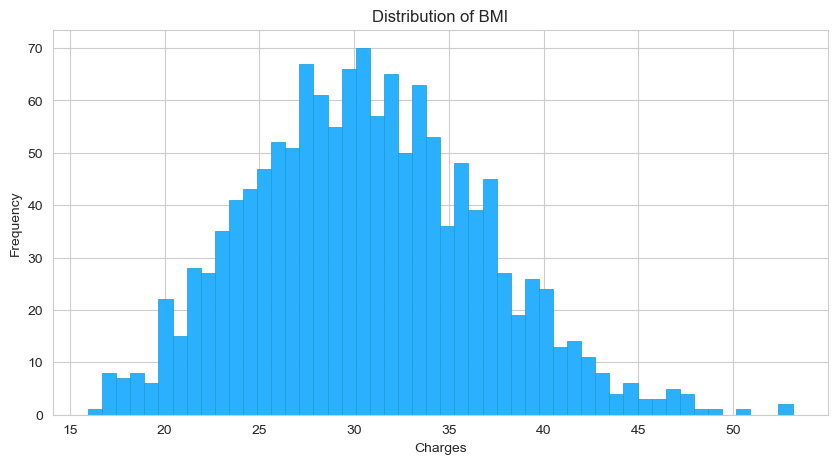

In [329]:
plt.figure(figsize=(10,5))
plt.hist(df['bmi'], bins=50, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

plt.title('Distribution of BMI')
plt.xlabel('Charges')
plt.ylabel('Frequency')

We saw earlier that the average individual has a BMI of 30.66. An overweight person has a BMI in the range of 25-29.9 and an obese individual in the range of 30-34.9. The dataset evidently includes many individuals who struggle with weight issues.

<br>

Text(7.625000000000009, 0.5, 'Amount')

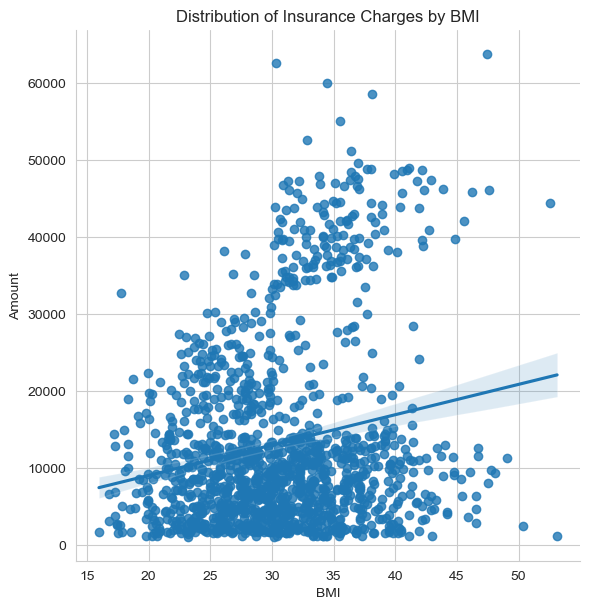

In [330]:
sns.lmplot(x='bmi', y='charges', data=df, height=6)

plt.title('Distribution of Insurance Charges by BMI')
plt.xlabel('BMI')
plt.ylabel('Amount')

The charges of individuals by BMI forms two subsets: the large section at the bottom which remains between the 0-15000 range and the ascending section at the top which increases in cost as BMI grows. Given that the two groups appear to be disparate, it would be feasible to apply a color filter for smokers since we have seen how the age groups were split into multiple sections by smoking habit.

<br>

## BMI & Smoking

<br>

Text(0.5, 1.0, 'Distribution of Insurance Charges by BMI & Smoking Habit')

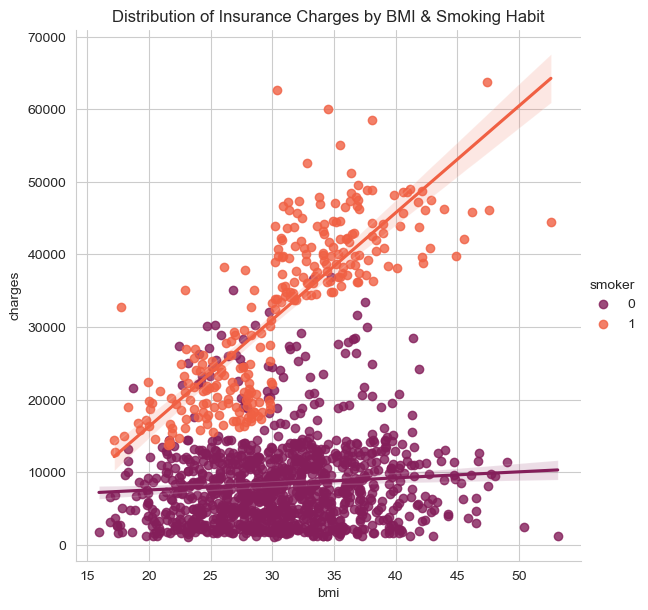

In [331]:
sns.lmplot(x='bmi', y='charges', hue='smoker', data=df, palette='rocket', height=6)
plt.title('Distribution of Insurance Charges by BMI & Smoking Habit')

Now we are able to see the picture more clearly. Non-smokers tend to maintain their insurance charges within a moderate range as their BMI grows. Smokers, however, tend to have a positive correlation between BMI and charges, which suggests that higher BMIs are much more deadly for smokers than non-smokers. Once again, smoking stands out as the most important factor in determining an individual's insurance costs. Non-smokers can be overweight but not face nearly as many health challenges as smokers.

<br>

## Age & BMI

Text(30.875, 0.5, 'BMI')

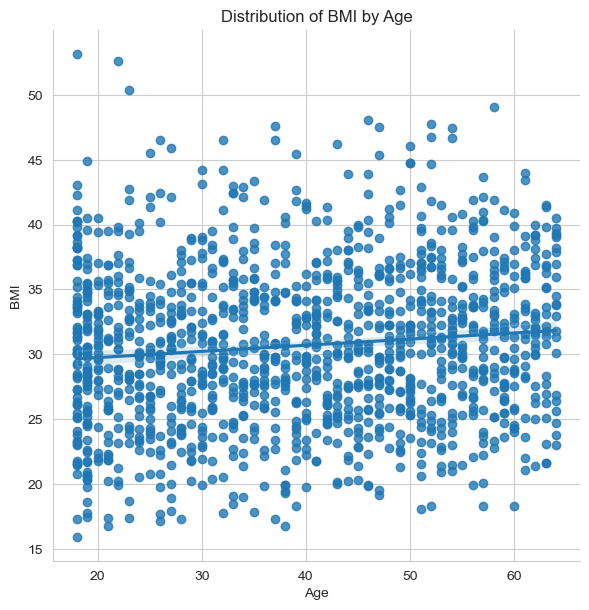

In [332]:
sns.lmplot(x='age', y='bmi', data=df, height=6)

plt.title('Distribution of BMI by Age')
plt.xlabel('Age')
plt.ylabel('BMI')

<br>

Unfortunately, there is discernable relationship between Age and BMI. Younger people are as likely to be overweight (BMI 25+) as the elderly.

<br>

## Sex

While Sex was not an important predictor for insurance charges, we did notice that men were more likely to be smokers than women. This might tell us that there could be something to be learned from the sex of the subject, even if the reason for smoking is purely cultural rather than physical.

Let's take a look at the relationship between Sex with Age, BMI and Charges.

<br>

In [333]:
# Where 0 is female and 1 is male.

df.groupby(by='sex').mean()

,age,bmi,children,smoker,region,charges
sex,,,,,,
0,39.503,30.378,1.074,0.174,1.511,12569.579
1,38.917,30.943,1.115,0.235,1.521,13956.751


Text(0, 0.5, 'Frequency')

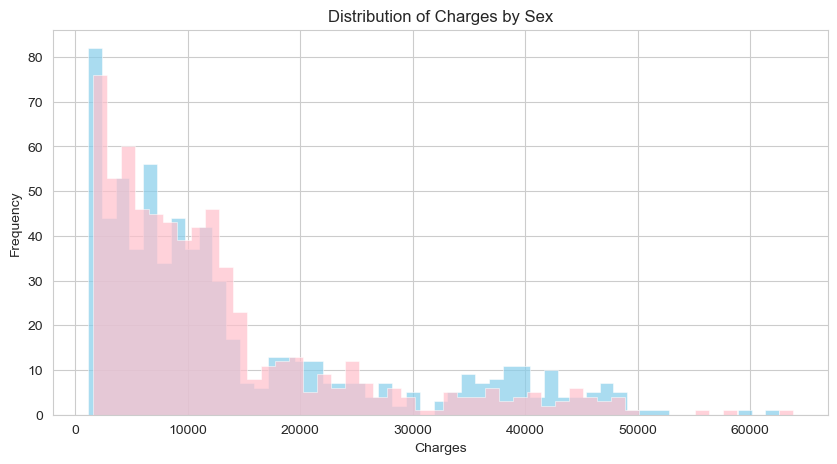

In [334]:
male = df.query('sex == 1')
female = df.query('sex == 0')

plt.figure(figsize=(10,5))
plt.hist(male['charges'], histtype='stepfilled', alpha=0.7, color='skyblue', bins=50, linewidth=0.5)
plt.hist(female['charges'], histtype='stepfilled', alpha=0.7, color='pink', bins=50, linewidth=0.5)

plt.title('Distribution of Charges by Sex')
plt.xlabel('Charges')
plt.ylabel('Frequency')

<br>

There are a nearly equal number of both sexes in the dataset. Men (13956.75) generally have a higher insurance cost than women (12569.58). Men are also more likely to be smokers than women, which we already know is a strong correlative factor with charges. With regards to the distribution of charges, the difference between men and women is not so stark. Women tend to have marginally higher frequency in the lower range where as men are often twice as frequent in the higher range. Both groups generally folllow the same pattern.

<br>

## Sex & BMI

Text(0, 0.5, 'Frequency')

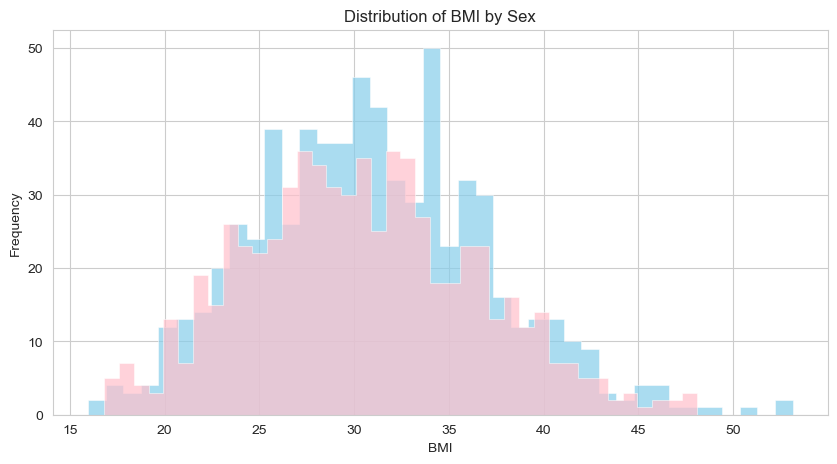

In [335]:
plt.figure(figsize=(10,5))
plt.hist(male['bmi'], histtype='stepfilled', alpha=0.7, color='skyblue', bins=40, linewidth=0.5)
plt.hist(female['bmi'], histtype='stepfilled', alpha=0.7, color='pink', bins=40, linewidth=0.5)

plt.title('Distribution of BMI by Sex')
plt.xlabel('BMI')
plt.ylabel('Frequency')

Nothing particular to note here. Most men and women are around the BMI range of 25-35, which corresponds to a range of overweight (25-29.9) and obese (30-34.9). The distribution of BMI is relatively similar across both sexes.

<br>

## Sex & Smoking

We expect smoking to be a strongly negative effect on both sexes but would like to see if there are noticeable difference in insurance charges against male smokers compared to female smokers.

In [336]:
male_smokers = male.query('smoker == 1')
male_non_smokers = male.query('smoker == 0')
female_smokers = female.query('smoker == 1')
female_non_smokers = female.query('smoker == 0')

In [337]:
male_smokers.mean()

age           38.447
sex            1.000
bmi           31.504
children       1.189
smoker         1.000
region         1.572
charges    33042.006
dtype: float64

In [338]:
female_smokers.mean()

age           38.609
sex            0.000
bmi           29.608
children       1.009
smoker         1.000
region         1.426
charges    30678.996
dtype: float64

In [339]:
male_non_smokers.mean()

age          39.062
sex           1.000
bmi          30.771
children      1.093
smoker        0.000
region        1.505
charges    8087.205
dtype: float64

In [340]:
female_non_smokers.mean()

age          39.691
sex           0.000
bmi          30.540
children      1.088
smoker        0.000
region        1.528
charges    8762.297
dtype: float64

<br>

The average male smoker is about the same age as the female smoker. He is, however, noticeably heavier in his BMI (31.50 > 29.61) and pays about 2500 more on insurance per year. Most of the data for non-smokers is also similar, but the noticeable difference occurs between the insurance charges: female non-smokers pay only \\$700 more than male non-smokers. If we remember  correctly, the average smoker pays \\$24000 more for insurance than non-smokers. It is evident that Smoking is the most important variable in the dataset, with the other variables just giving more insight and clarity into the relationship between Smoking and Charges.

<br>

Text(0.5, 1.0, 'Charges of Women by Smoking Habit')

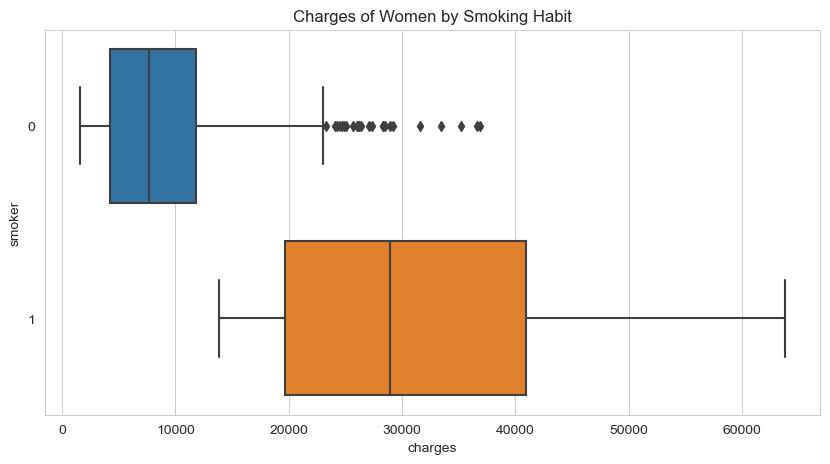

In [341]:
plt.figure(figsize=(10,5))
sns.boxplot(y='smoker', x='charges', data=df[(df.sex == 0)], orient='h')
plt.title('Charges of Women by Smoking Habit')

Text(0.5, 1.0, 'Charges of Men by Smoking Habit')

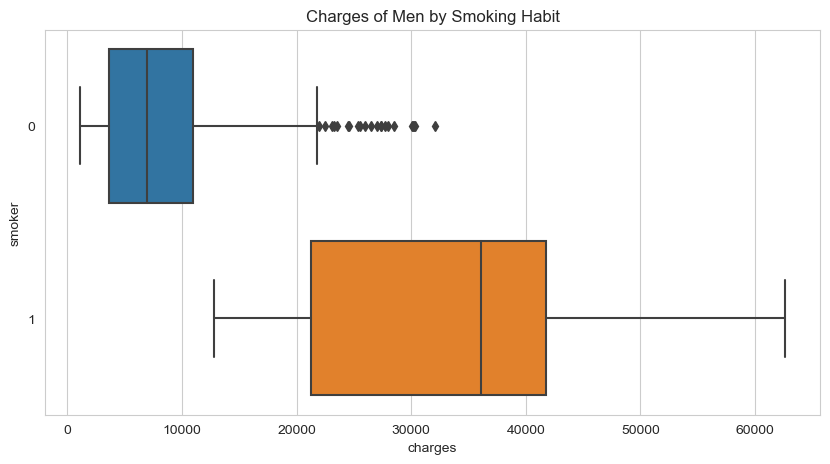

In [342]:
plt.figure(figsize=(10,5))
sns.boxplot(y='smoker', x='charges', data=df[(df.sex == 1)], orient='h')
plt.title('Charges of Men by Smoking Habit')

We can see the monumental difference in cost between smokers and non-smokers. This difference is visible across both sexes. The median cost for both sexes is several times higher for smokers than for non-smokers. It seems that smoking has a strongly negative effect on the physical health of both women and men alike. There is no substantial difference between the sexes as the negative effect seems to be relatively equal.

<br>

## Sex, Smoking & BMI


Text(0, 0.5, 'Frequency')

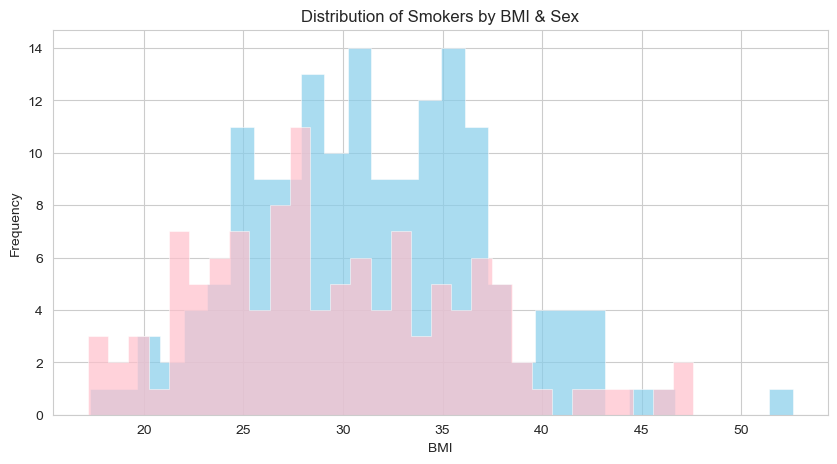

In [343]:
plt.figure(figsize=(10,5))
plt.hist(male_smokers['bmi'], histtype='stepfilled', alpha=0.7, color='skyblue', bins=30, linewidth=0.5)
plt.hist(female_smokers['bmi'], histtype='stepfilled', alpha=0.7, color='pink', bins=30, linewidth=0.5)

plt.title('Distribution of Smokers by BMI & Sex')
plt.xlabel('BMI')
plt.ylabel('Frequency')

<br>

Men are considerably more likely to be both overweight and smokers (note that a BMI of 25+ is overweight and 30+ is obese). We have already seen how BMI and smoking tend to have a compounding effect on raising insurance charges. The average BMI is 30.94 for men and 30.38 for women - both of which are in the obese range. Evidently, this dataset involves many unhealthy individuals. But since men are more likely to be overweight smokers than women, it is perhaps not surprising that the health costs for men have such a noticeable gap as we had mentioned earlier (1400 dollar sex gap for all individuals, 2500 for just smokers). 

Let us attempt to see how Age, BMI and Sex all interact as variables to see if Age and Sex can be used to predict BMI.

<br>

## Age, Sex & BMI

Text(0.02, 0.5, 'BMI')

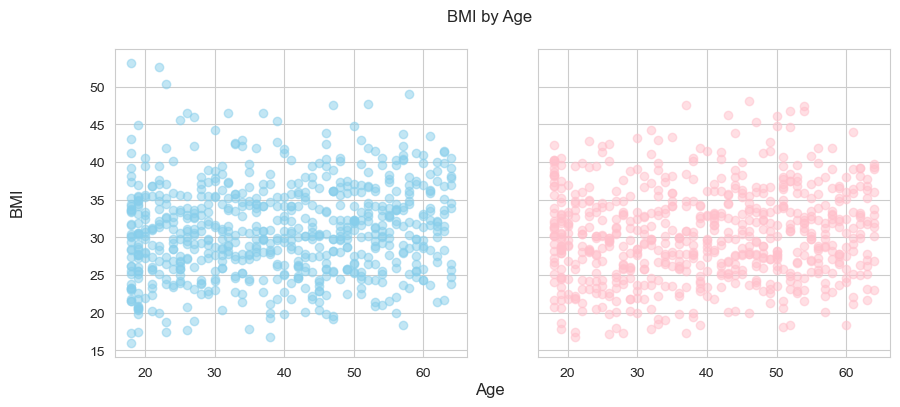

In [344]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

ax1.scatter(male['age'], male['bmi'], alpha=0.5, c='skyblue')
ax2.scatter(female['age'], female['bmi'], alpha=0.5, c='pink')

fig.suptitle("BMI by Age")
fig.supxlabel('Age')
fig.supylabel('BMI')

For both men and women, the relation between Age and BMI is unclear when divided by sex. Perhaps a look at smoking men and smoking women might give us a different look?

## Age, Sex, Smoking & BMI

Text(0.02, 0.5, 'BMI')

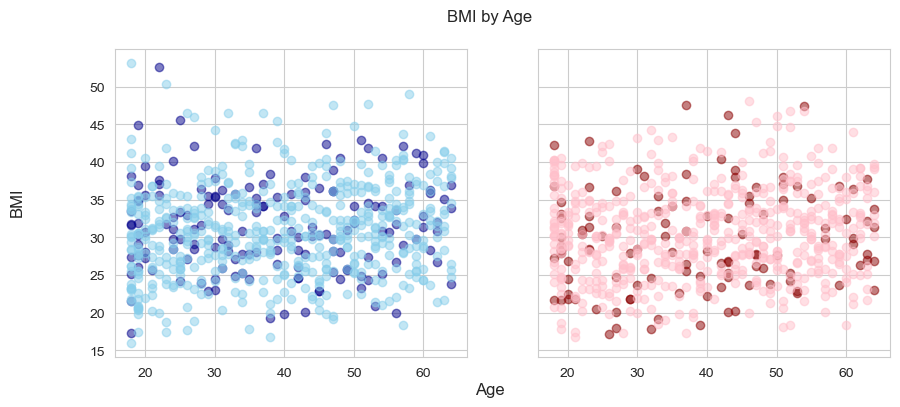

In [345]:
# Smokers in dark, non-smokers in light.

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,4))

ax1.scatter(male_smokers['age'], male_smokers['bmi'], alpha=0.5, c='darkblue')
ax1.scatter(male_non_smokers['age'], male_non_smokers['bmi'], alpha=0.5, c='skyblue')
ax2.scatter(female_smokers['age'], female_smokers['bmi'], alpha=0.5, c='darkred')
ax2.scatter(female_non_smokers['age'], female_non_smokers['bmi'], alpha=0.5, c='pink')

fig.suptitle("BMI by Age")
fig.supxlabel('Age')
fig.supylabel('BMI')

<br>

Once again, the smokers are not discernable from the non-smokers. We would have to conclude that there is no noticeable relationship between Age, Sex, Smoking and BMI.

<br>

## Modeling the Data

Now that we've taken a look at the four factors which are crucial to determining the cost of insurance, let us build a model that can successfully estimate the cost of an arbitrary individual's insurance. Given that the data is likely going to require a linear regression with 4-6 variables, we are going to begin by attempting to use least-squared linear regression, ridge regression and lasso regression. The r-squared will be evaluated for each one to ensure that we are able to have a high level of accuracy in prediction.

<br>

## Linear Regression

In [346]:
X = df.drop(['charges'], axis = 1)
y = df.charges

In [347]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1


In [348]:
y.head()

0   16884.924
1    1725.552
2    4449.462
3   21984.471
4    3866.855
Name: charges, dtype: float64

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
lr = LinearRegression().fit(X_train, y_train)

In [350]:
print("Coefficient: {}".format(lr.coef_))
print("Intercept: {:.2f}".format(lr.intercept_))

Coefficient: [ 2.50537556e+02  3.65092141e+00  3.22881906e+02  4.50147445e+02
  2.36021161e+04 -3.41244000e+02]
Intercept: -11261.14


In [351]:
print("Training set score: {:.3f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lr.score(X_test, y_test)))

Training set score: 0.734
Test set score: 0.796


<br>

We can see that the 0.80 R-squared is decent but not particularly good. Rather than an OLS regression, let us try Ridge and Lasso regression to see if we can build a better model.

<br>

In [352]:
ridge = Ridge(alpha=10).fit(X_train, y_train)
print("Training set score: {:.3f}".format(ridge.score(X_train, y_train)))
print("Test set score: {:.3f}".format(ridge.score(X_test, y_test)))

Training set score: 0.732
Test set score: 0.792


In [353]:
lasso = Lasso(alpha=10).fit(X_train, y_train)
print("Training set score: {:.3f}".format(lasso.score(X_train, y_train)))
print("Test set score: {:.3f}".format(lasso.score(X_test, y_test)))
print("Number of features used: {}".format(np.sum(lasso.coef_ != 0)))

Training set score: 0.734
Test set score: 0.796
Number of features used: 5


<br>

Neither Ridge nor Lasso regression works particularly well. Adjusting the alpha doesn't make a significant different either in increasing the r-squared. 

<br>

### RandomForestRegressor

In [354]:
# Leaving n_estimators at 100 yielded the best results. 10 yielded an r-squared of 0.96 rather than 0.975, 
# whereas 1000 took too to compute with effectively no difference in r-squared (still 0.975).

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0, oob_score = True)
regressor.fit(X, y)

RandomForestRegressor(oob_score=True, random_state=0)

In [355]:
from sklearn.metrics import mean_squared_error, r2_score

oob_score = regressor.oob_score_

predictions = regressor.predict(X)

# Calculating Mean Squared Error and R2.
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print('Out of the bag score: {}'.format(oob_score))
print('MSE: {}'.format(mse))
print('R2: {}'.format(r2))

Out of the bag score: 0.8319142581833602
MSE: 3491860.9720099675
R2: 0.9761717275061563


<br>

Looks like the RandomForestRegressor was able to yield a model with an r-squared of 0.976. It appears that this would be sufficient for predicting future data points.

## Conclusion

<br>

This project involved the exploration of a dataset containing the insurance costs of individual patients. The individuals were separated by six categories, of which the four most important were explored: Age, Sex, BMI and Smoking. It was found that Smoking is the most important factor in predicting insurance costs (with a correlation of 0.79). Linear regression was used to develop a predictive model but did not yield a sufficiently large r-squared value. Random Forest Regressor, which combines bootstrapping with ensemble learning, was successful in providing a model with an r-squared of 0.976.

Thanks for reading,

JD